### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data
### To do: Take necessary actions to read the data

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Cancer Detection/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Cancer Detection/Test/')



In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

## Create a dataset
#### Defining some parameters

In [5]:
batch_size=32
img_height= 180
img_width=180


#### Use 80% of the images for training and rest 20% for validation

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data

### To do, create a code to visualize one instance of all the nine classes present in the dataset

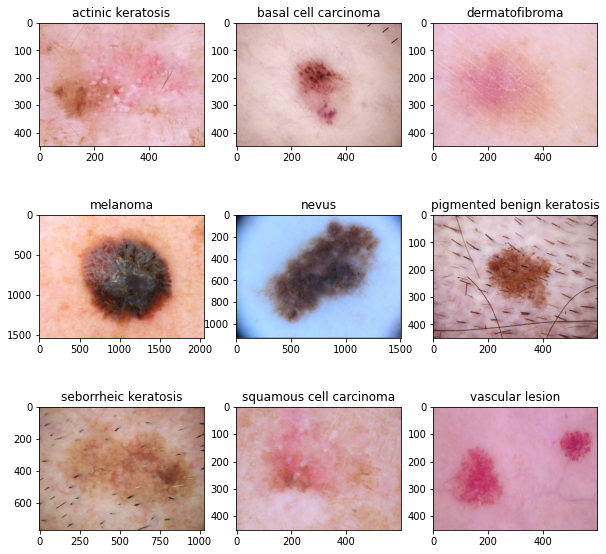

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:
### Your code goes here

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  
])

## Compile the model

####Choose an appropriate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 79s 1s/step - loss: 1.9214 - accuracy: 0.2701 - val_loss: 1.6521 - val_accuracy: 0.4318
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5738 - accuracy: 0.4609 - val_loss: 1.4716 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4299 - accuracy: 0.4994 - val_loss: 1.4430 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2979 - accuracy: 0.5463 - val_loss: 1.3417 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1889 - accuracy: 0.5781 - val_loss: 1.4585 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1219 - accuracy: 0.6021 - val_loss: 1.4689 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0022 - accuracy: 0.6429 - val_loss: 1.5735 - val_accuracy: 0.4944
Epoch 8/20
56/

## Visualizing training results

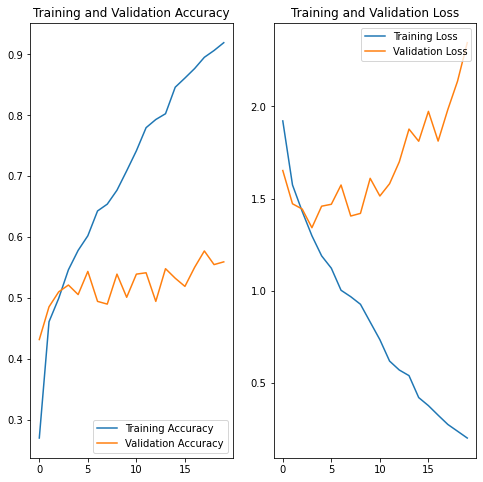

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here

Findings after the first model run:

1. This is clearly a case of overfitting as is evident by the training and validation accuracy. We can see that with increasing epochs, training accuracy almost increases linearly but validation accuracy has stagnated around 50-60%.
2. We can also see from the training and validation loss graphs athat around epoch number 5, validation loss starts increasing rapidly which indicates overfitting.
3. We need treatment to solve the overfitting in this first iteration.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

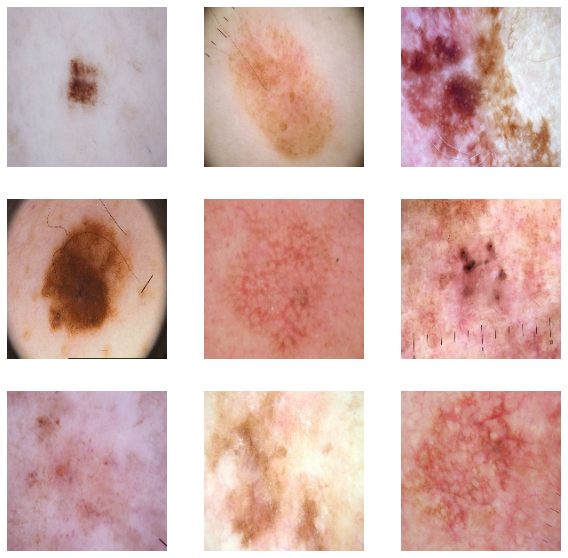

In [44]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

## Todo:
## Create the model, compile and train the model

In [18]:
### Your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



## Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

##Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
## Training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 31ms/step - loss: 2.0562 - accuracy: 0.2439 - val_loss: 1.9210 - val_accuracy: 0.2707
Epoch 2/20
56/56 [==============================] - 1s 27ms/step - loss: 1.8078 - accuracy: 0.3276 - val_loss: 1.6682 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6178 - accuracy: 0.4263 - val_loss: 1.5332 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5103 - accuracy: 0.4727 - val_loss: 1.4527 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4091 - accuracy: 0.5028 - val_loss: 1.3746 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3883 - accuracy: 0.5084 - val_loss: 1.4391 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3286 - accuracy: 0.5324 - val_loss: 1.3662 - val_accuracy: 0.5168
Epoch 8/20
56

## Visualizing the results

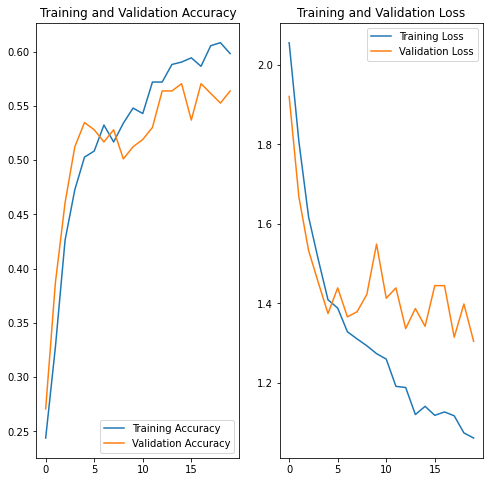

In [22]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


Findings after the second model run:

1. There is no improvement in validation accuracy at large but we can see that the overfitting problem has been solved to some extent by looking at the accuracy as well as loss graphs by using the strategy of data augmentation
2. We can increase the epochs to see an improvement in accuracy numbers possibly

## Todo: Find the distribution of classes in the training dataset.

## Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
from pathlib import Path

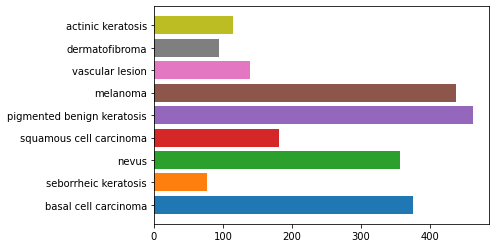

In [24]:
import os
path = '/content/gdrive/MyDrive/Cancer Detection/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

## Todo: Write your findings here:
- Which class has the least number of samples? Seborrheic Keratosis
- Which classes dominate the data in terms proportionate number of samples? Pigmented Benign Keratosis

## Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [26]:
path_to_training_dataset='/content/gdrive/MyDrive/Cancer Detection'
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

/content/gdrive/MyDrive/Cancer Detection/Train


In [27]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFAA20DF490>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FFA87D4D590>: 100%|██████████| 500/500 [00:21<00:00, 23.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFB21864550>: 100%|██████████| 500/500 [00:22<00:00, 22.27 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FFB1EA0A5D0>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FFA87D02BD0>: 100%|██████████| 500/500 [01:24<00:00,  5.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFA8DBE0250>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FFA8DBCBF50>: 100%|██████████| 500/500 [00:44<00:00, 11.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFB1E960A10>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Cancer Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FFB1EA38610>: 100%|██████████| 500/500 [00:18<00:00, 26.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [29]:
print(data_dir_train)

/content/gdrive/MyDrive/Cancer Detection/Train


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
import glob

In [32]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Todo: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

## Todo: Create a training dataset

In [38]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Todo: Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Todo: Create your model (make sure to include normalization)

In [40]:
## your code goes here
## your code goes here

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.3132353 0.97205865


## Todo: Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Todo: Train your model

In [42]:
epochs= 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 43s 243ms/step - loss: 1.1908 - accuracy: 0.5466 - val_loss: 1.1044 - val_accuracy: 0.5865
Epoch 2/50
169/169 [==============================] - 32s 181ms/step - loss: 1.1119 - accuracy: 0.5770 - val_loss: 1.0408 - val_accuracy: 0.5999
Epoch 3/50
169/169 [==============================] - 32s 184ms/step - loss: 1.0900 - accuracy: 0.5864 - val_loss: 1.3358 - val_accuracy: 0.5501
Epoch 4/50
169/169 [==============================] - 31s 177ms/step - loss: 1.0290 - accuracy: 0.6048 - val_loss: 1.0250 - val_accuracy: 0.6318
Epoch 5/50
169/169 [==============================] - 30s 173ms/step - loss: 0.9944 - accuracy: 0.6224 - val_loss: 1.0535 - val_accuracy: 0.6199
Epoch 6/50
169/169 [==============================] - 30s 173ms/step - loss: 0.9640 - accuracy: 0.6341 - val_loss: 0.9815 - val_accuracy: 0.6385
Epoch 7/50
169/169 [==============================] - 32s 178ms/step - loss: 0.9353 - accuracy: 0.6454 - val_loss: 0.9588 - val_ac

## Todo: Visualize the model results

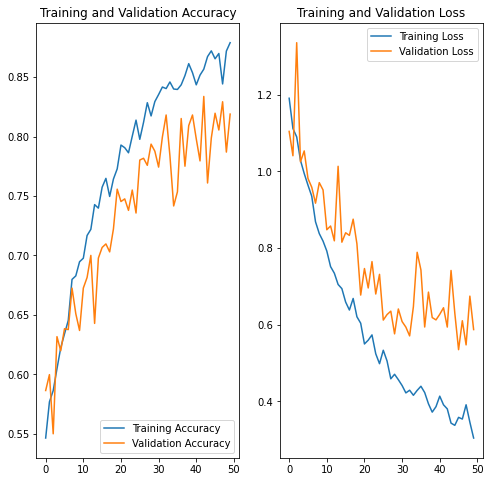

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Findings after the third model run:

1. We have managed to increase the training accuracy after using Augmentor library
2. Model is still slightly overfitting but has improved a lot now, we are getting decent validation accuracy around 82-83%
3. The problem of overfitting can be solved by adding more layers,neurons or adding dropout layers.
4. Aso, the Model can be further improved by tuning the hyperparameter